<a href="https://colab.research.google.com/github/Emma-Cap/Deep-Learning-Project/blob/main/FORSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math
import cv2
import numpy as np

# Specifica il percorso del file zip
zip_path = '/content/archive.zip'

# Specifica la directory dove vuoi estrarre il file zip
extract_path = '/content/dataset'

# Estrai il file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Visualizza il contenuto delle directory estratte
for root, dirs, files in os.walk(extract_path):
    print(f"In directory: {root}")
    print(f"Cartelle: {dirs}")

In directory: /content/dataset
Cartelle: ['faces_02', 'faces']
In directory: /content/dataset/faces_02
Cartelle: ['part3']
In directory: /content/dataset/faces_02/part3
Cartelle: []
In directory: /content/dataset/faces
Cartelle: ['Train']
In directory: /content/dataset/faces/Train
Cartelle: []


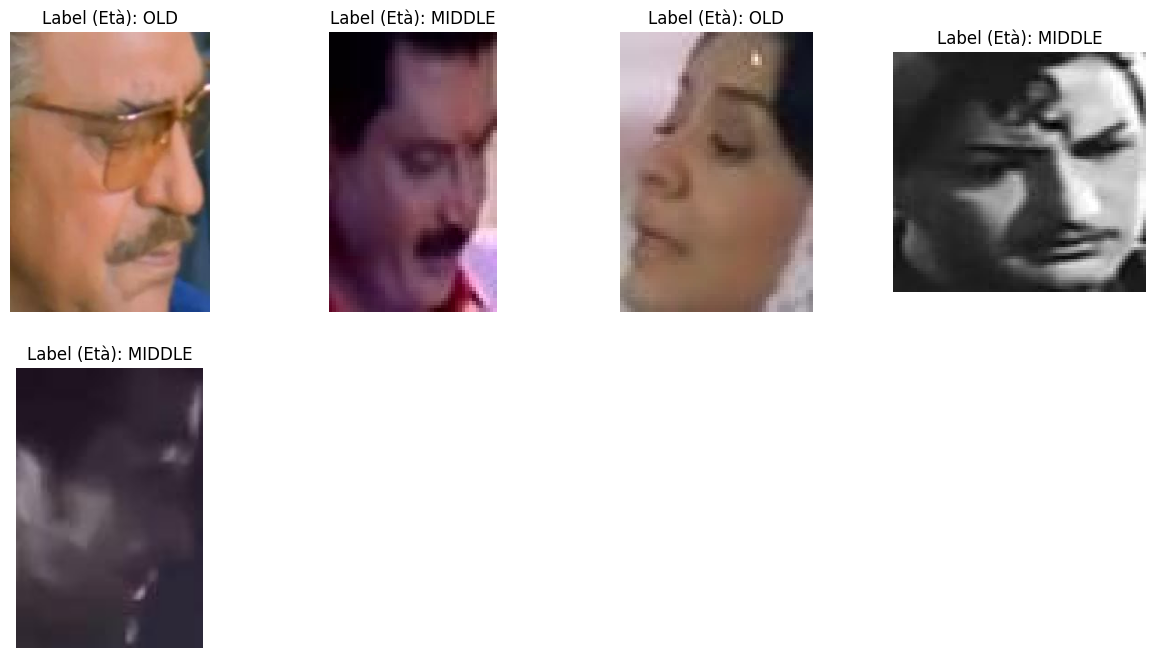

In [2]:
# Percorso del file CSV e della cartella immagini
annotations_file = '/content/dataset/faces/train.csv'
images_dir = '/content/dataset/faces/Train'

# Leggi il file CSV
annotations = pd.read_csv(annotations_file)

# Campiona casualmente 5 immagini
sample_images = annotations.sample(5)

# Configura il numero di colonne desiderato per mostrare le immagini affiancate
columns = 4

# Calcola il numero di righe necessario
rows = math.ceil(len(sample_images) / columns)

# Crea una figura e una griglia
fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 4))
axes = axes.flatten()  # Rende la griglia un array monodimensionale per iterazione semplice

# Itera sulle immagini e mostrale
for idx, (ax, (_, row)) in enumerate(zip(axes, sample_images.iterrows())):
    image_path = os.path.join(images_dir, row['ID'])  # Usa la colonna 'ID' per il nome del file
    label = row['Class']  # Usa la colonna 'Class' per la label

    # Carica e mostra l'immagine
    img = Image.open(image_path)
    ax.imshow(img)
    ax.set_title(f"Label (Età): {label}")
    ax.axis('off')

# Nascondi gli assi extra se ci sono meno immagini che celle nella griglia
for ax in axes[len(sample_images):]:
    ax.axis('off')

# Mostra la figura finale
#plt.tight_layout()
#plt.show()


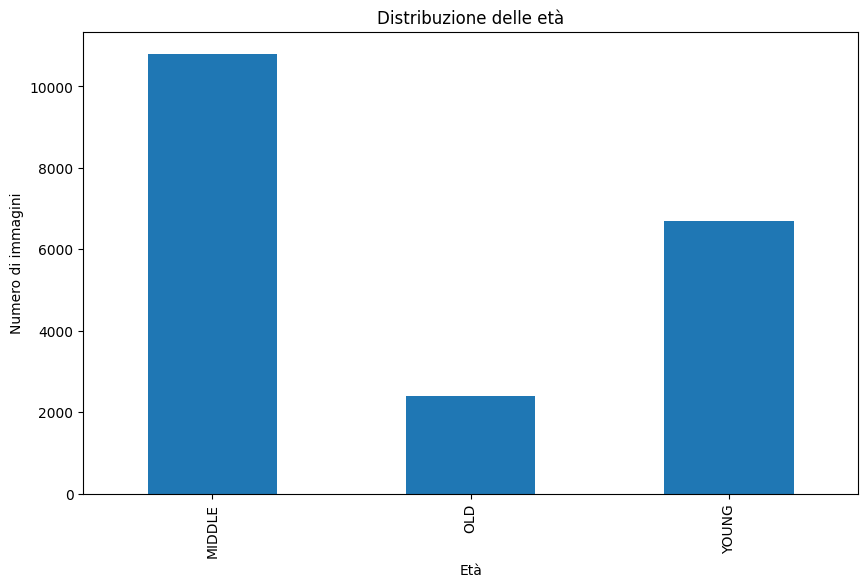

In [3]:
# Distribuzione delle età
age_distribution = annotations['Class'].value_counts().sort_index()

# Plot distribuzione
plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('Distribuzione delle età')
plt.xlabel('Età')
plt.ylabel('Numero di immagini')
plt.show()

In [4]:
import os
from PIL import Image
import pandas as pd
import cv2
import torchvision.transforms as transforms
from tqdm import tqdm

# Supponiamo che queste variabili esistano già
# annotations: DataFrame con ID e Class delle immagini originali
# images_dir: Directory contenente le immagini originali
# output_dir: Directory dove salveremo tutte le immagini finali
output_dir = 'final_images'
os.makedirs(output_dir, exist_ok=True)

# **1. Filtra immagini con rumore elevato**
noise_threshold = 500
low_quality_images = []

for img_name in annotations['ID']:
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        laplacian = cv2.Laplacian(img, cv2.CV_64F)
        variance = laplacian.var()
        if variance > noise_threshold:
            low_quality_images.append(img_name)

# **2. Filtra immagini a bassa risoluzione**
for img_name in annotations['ID']:
    img_path = os.path.join(images_dir, img_name)
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            resolution = width * height
            if resolution < 10000:  # Risoluzione bassa: 100x100
                low_quality_images.append(img_name)
    except Exception as e:
        print(f"Errore nell'aprire {img_path}: {e}")
        low_quality_images.append(img_name)

# Rimuoviamo duplicati dalla lista
low_quality_images_set = set(low_quality_images)

# Rimuovi tutte le immagini di bassa qualità dal DataFrame
filtered_annotations = annotations[~annotations['ID'].isin(low_quality_images_set)]
print(f"Immagini di bassa qualità rimosse: {len(low_quality_images_set)}")
print(f"Immagini rimanenti: {len(filtered_annotations)}")

# **3. Salva le immagini rimanenti**
for idx, row in filtered_annotations.iterrows():
    img_name = row['ID']
    img_path = os.path.join(images_dir, img_name)
    output_path = os.path.join(output_dir, img_name)
    try:
        with Image.open(img_path) as img:
            img.save(output_path)
    except Exception as e:
        print(f"Errore nel salvare {img_path}: {e}")

print(f"Immagini salvate nella directory finale: {len(filtered_annotations)}")

# **4. Salva il nuovo DataFrame con le annotazioni aggiornate**
filtered_annotations_file = os.path.join(output_dir, 'filtered_annotations.csv')
filtered_annotations.to_csv(filtered_annotations_file, index=False)
print(f"Annotazioni aggiornate salvate in: {filtered_annotations_file}")


Immagini di bassa qualità rimosse: 11692
Immagini rimanenti: 8214
Immagini salvate nella directory finale: 8214
Annotazioni aggiornate salvate in: final_images/filtered_annotations.csv


<ipython-input-5-e6596ae498ba>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-5-e6596ae498ba>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


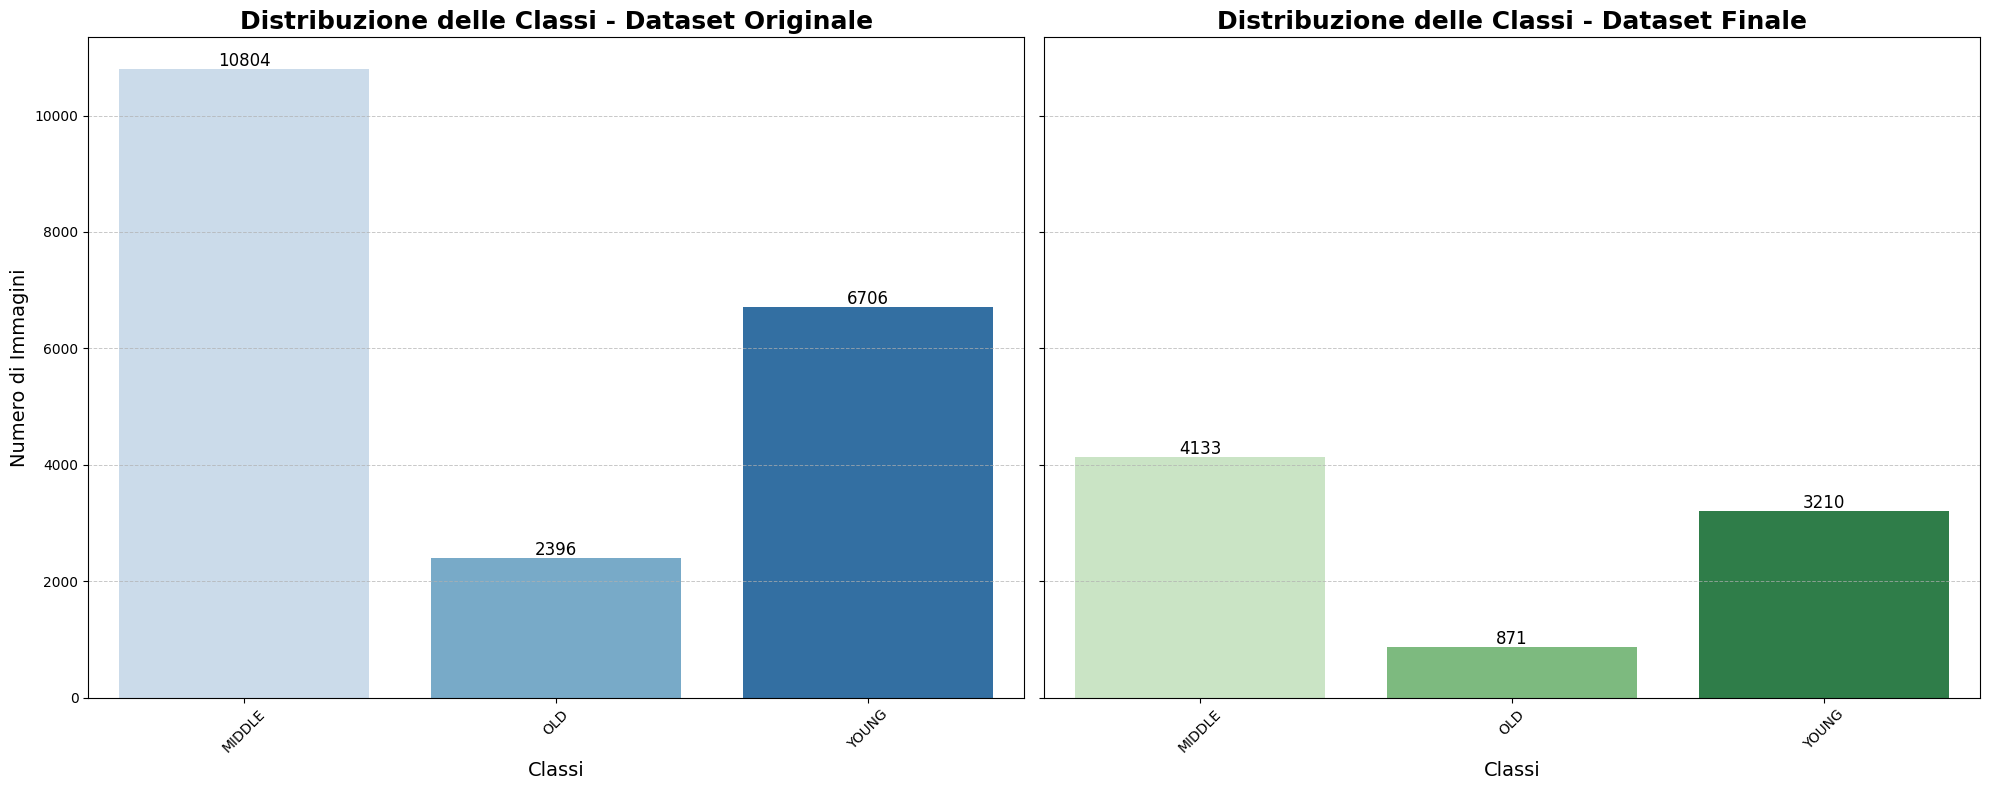

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ricarica il file delle annotazioni aggiornate
filtered_annotations_file = "final_images/filtered_annotations.csv"
filtered_annotations = pd.read_csv(filtered_annotations_file)

# Genera la distribuzione delle classi per dataset originale e finale
class_distribution_original = annotations['Class'].value_counts().sort_index()
class_distribution_final = filtered_annotations['Class'].value_counts().sort_index()

# Crea una figura con due subplot affiancati per il confronto
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Colori per i plot
palette_original = sns.color_palette("Blues", len(class_distribution_original))
palette_final = sns.color_palette("Greens", len(class_distribution_final))

# Plot per il dataset originale
sns.barplot(
    x=class_distribution_original.index,
    y=class_distribution_original.values,
    palette=palette_original,
    ax=axes[0]
)
axes[0].set_title('Distribuzione delle Classi - Dataset Originale', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Classi', fontsize=14)
axes[0].set_ylabel('Numero di Immagini', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_original.values):
    axes[0].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Plot per il dataset finale
sns.barplot(
    x=class_distribution_final.index,
    y=class_distribution_final.values,
    palette=palette_final,
    ax=axes[1]
)
axes[1].set_title('Distribuzione delle Classi - Dataset Finale', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Classi', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_final.values):
    axes[1].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il grafico finale
plt.show()



In [6]:
import os
import pandas as pd
from PIL import Image
import random

# Directory e file delle annotazioni aggiornate
output_dir = "final_images"
filtered_annotations_file = os.path.join(output_dir, "filtered_annotations.csv")

# Carichiamo le annotazioni aggiornate
filtered_annotations = pd.read_csv(filtered_annotations_file)

# Calcola il numero di immagini attuali per classe
class_distribution = filtered_annotations['Class'].value_counts()
print("Distribuzione iniziale delle classi:")
print(class_distribution)

# Determina il numero di immagini della classe meno numerosa
min_class_size = class_distribution.min()

# Trova le classi con più immagini rispetto alla classe meno numerosa
classes_to_reduce = class_distribution[class_distribution > min_class_size].index.tolist()

# Rimuovi immagini casualmente solo dalle classi più numerose
images_to_remove = []
for class_name in classes_to_reduce:
    class_images = filtered_annotations[filtered_annotations['Class'] == class_name]
    num_to_remove = len(class_images) - min_class_size

    # Campioniamo casualmente le immagini da rimuovere
    images_to_remove += class_images.sample(num_to_remove, random_state=42)['ID'].tolist()

# Aggiorna le annotazioni rimuovendo le immagini selezionate
balanced_annotations = filtered_annotations[~filtered_annotations['ID'].isin(images_to_remove)]
print(f"Numero totale di immagini rimosse: {len(images_to_remove)}")
print("Distribuzione aggiornata delle classi:")
print(balanced_annotations['Class'].value_counts())

# Salva le annotazioni bilanciate
balanced_annotations_file = os.path.join(output_dir, "balanced_annotations.csv")
balanced_annotations.to_csv(balanced_annotations_file, index=False)
print(f"Annotazioni aggiornate salvate in: {balanced_annotations_file}")

# Rimuovi le immagini non necessarie dalla directory
for img_name in images_to_remove:
    img_path = os.path.join(output_dir, img_name)
    if os.path.exists(img_path):
        os.remove(img_path)

print("Immagini non necessarie rimosse.")


Distribuzione iniziale delle classi:
Class
MIDDLE    4133
YOUNG     3210
OLD        871
Name: count, dtype: int64
Numero totale di immagini rimosse: 5601
Distribuzione aggiornata delle classi:
Class
MIDDLE    871
YOUNG     871
OLD       871
Name: count, dtype: int64
Annotazioni aggiornate salvate in: final_images/balanced_annotations.csv
Immagini non necessarie rimosse.


In [31]:
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm

# Percorsi originali
final_images_dir = "final_images"  # Directory delle immagini originali
balanced_annotations_file = os.path.join(final_images_dir, "balanced_annotations.csv")

# Carica le annotazioni originali
balanced_annotations = pd.read_csv(balanced_annotations_file)

# Configura le trasformazioni per la data augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize((224, 224)),
])

# Directory per salvare le immagini augmentate
# Nota: Salviamo sempre nella directory originale per evitare modifiche strutturali.
num_augmentations_per_image = 2  # Numero di augmentazioni per immagine

# Aggiungi augmentazioni solo per le classi "MIDDLE" e "OLD"
classes_to_augment = ["MIDDLE", "OLD"]
augmented_data = []  # Nuove annotazioni augmentate

for _, row in tqdm(balanced_annotations.iterrows(), total=len(balanced_annotations)):
    img_name = row['ID']
    label = row['Class']
    img_path = os.path.join(final_images_dir, img_name)

    # Applica augmentazioni solo alle classi specifiche
    if label in classes_to_augment:
        with Image.open(img_path).convert("RGB") as img:
            for i in range(num_augmentations_per_image):
                # Genera un nome unico per l'immagine augmentata
                new_img_name = f"aug_{i}_{img_name}"
                new_img_path = os.path.join(final_images_dir, new_img_name)

                # Salva l'immagine augmentata nella directory originale
                augmented_img = augmentation_transforms(img)
                augmented_img.save(new_img_path)

                # Aggiungi l'immagine augmentata all'elenco
                augmented_data.append({"ID": new_img_name, "Class": label})

# Concatena le nuove annotazioni augmentate
augmented_annotations = pd.concat([balanced_annotations, pd.DataFrame(augmented_data)], ignore_index=True)

# Salva le annotazioni aggiornate
augmented_annotations_file = os.path.join(final_images_dir, "balanced_annotations.csv")
augmented_annotations.to_csv(augmented_annotations_file, index=False)

print(f"Data augmentation completata. Annotazioni aggiornate salvate in: {augmented_annotations_file}")



100%|██████████| 2613/2613 [00:22<00:00, 117.61it/s]

Data augmentation completata. Annotazioni aggiornate salvate in: final_images/balanced_annotations.csv


<ipython-input-32-7a0819f45506>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-32-7a0819f45506>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


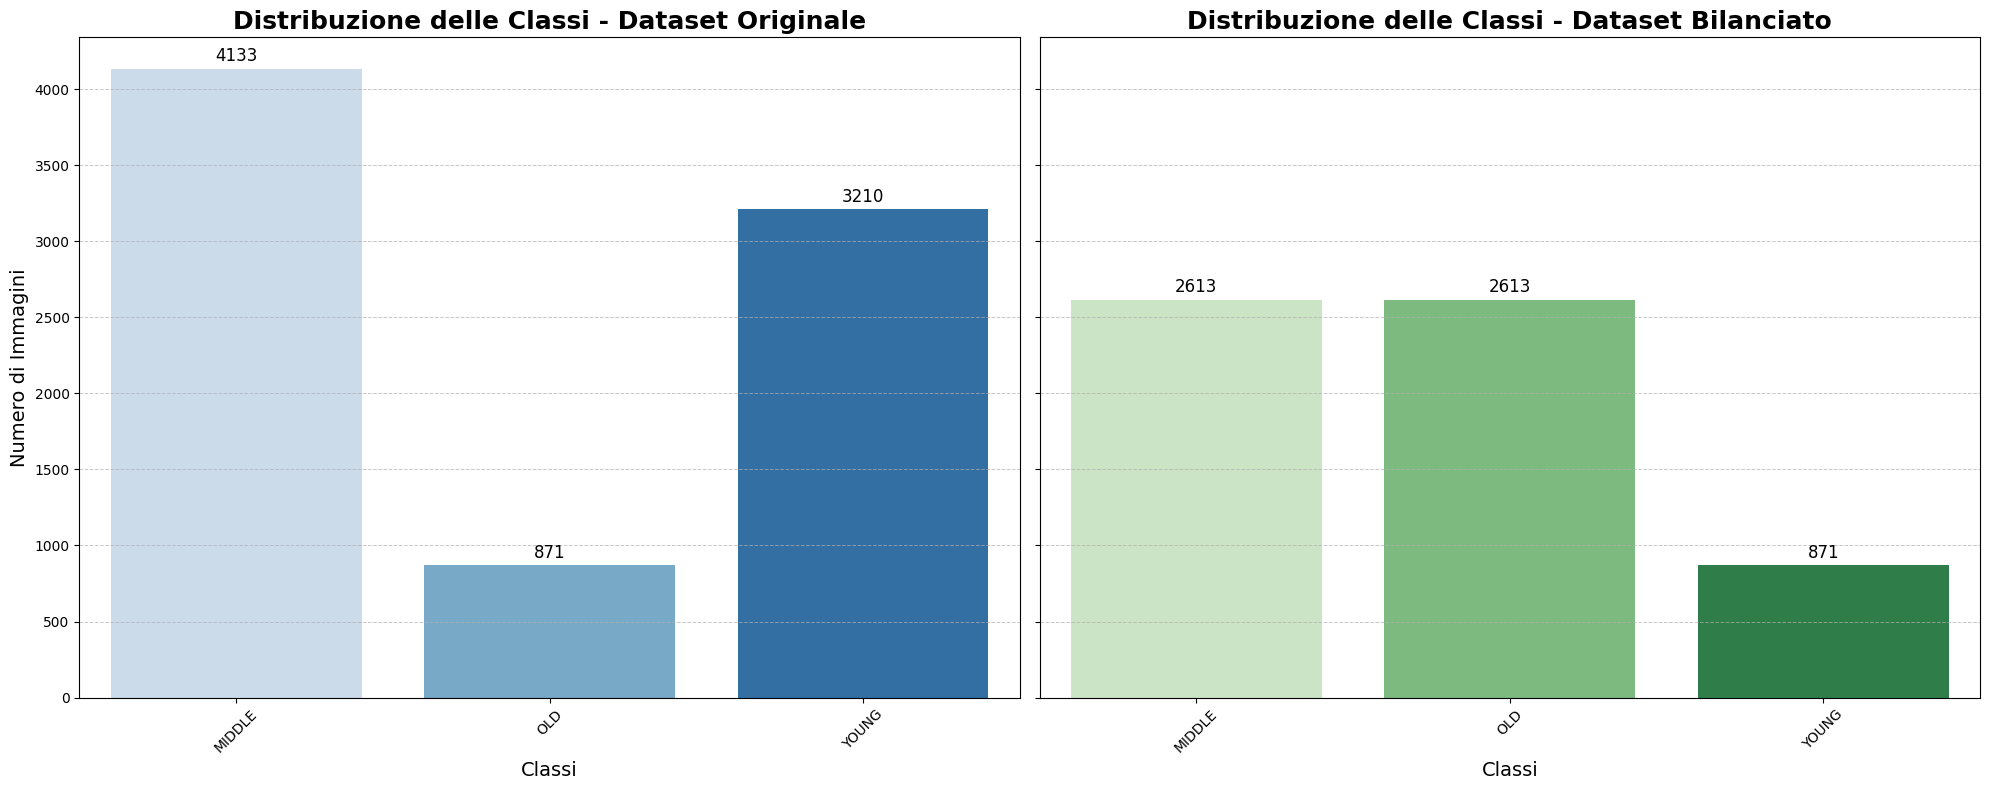

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ricarica il file delle annotazioni originali e bilanciate
filtered_annotations_file = "final_images/filtered_annotations.csv"
balanced_annotations_file = "final_images/balanced_annotations.csv"

original_annotations = pd.read_csv(filtered_annotations_file)
balanced_annotations = pd.read_csv(balanced_annotations_file)

# Genera la distribuzione delle classi per dataset originale e bilanciato
class_distribution_original = original_annotations['Class'].value_counts().sort_index()
class_distribution_balanced = balanced_annotations['Class'].value_counts().sort_index()

# Crea una figura con due subplot affiancati per il confronto
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Colori per i plot
palette_original = sns.color_palette("Blues", len(class_distribution_original))
palette_balanced = sns.color_palette("Greens", len(class_distribution_balanced))

# Plot per il dataset originale
sns.barplot(
    x=class_distribution_original.index,
    y=class_distribution_original.values,
    palette=palette_original,
    ax=axes[0]
)
axes[0].set_title('Distribuzione delle Classi - Dataset Originale', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Classi', fontsize=14)
axes[0].set_ylabel('Numero di Immagini', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_original.values):
    axes[0].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Plot per il dataset bilanciato
sns.barplot(
    x=class_distribution_balanced.index,
    y=class_distribution_balanced.values,
    palette=palette_balanced,
    ax=axes[1]
)
axes[1].set_title('Distribuzione delle Classi - Dataset Bilanciato', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Classi', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_balanced.values):
    axes[1].text(i, value + 50, str(value), ha='center', fontsize=12, color='black')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il grafico finale
plt.show()


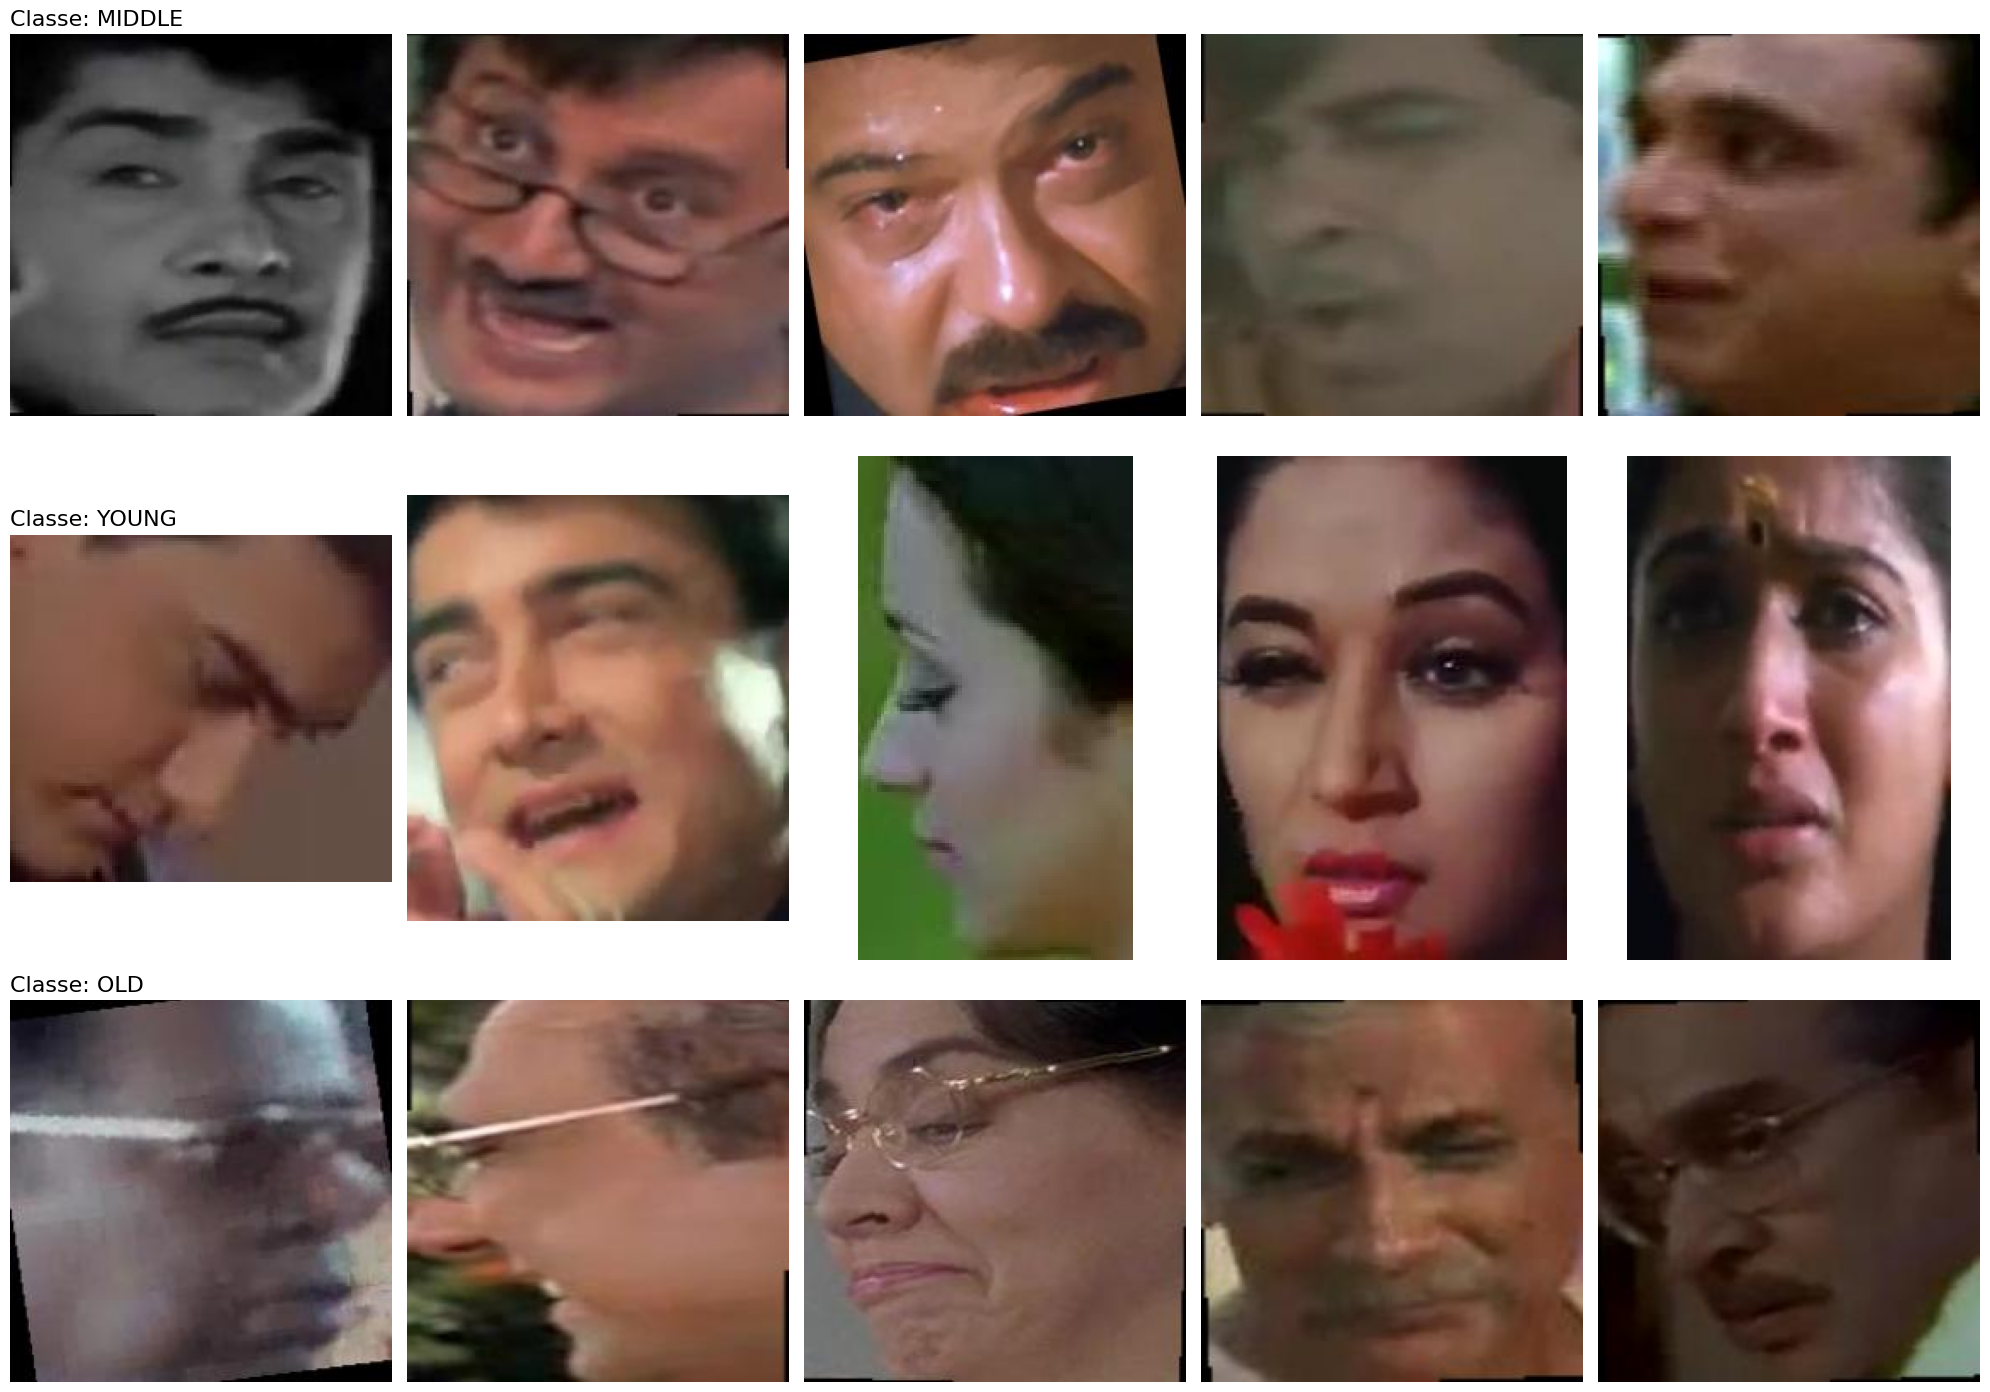

In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Carica le annotazioni bilanciate
balanced_annotations_file = "final_images/balanced_annotations.csv"
balanced_annotations = pd.read_csv(balanced_annotations_file)

# Directory delle immagini finali
output_dir = "final_images"

# Numero di immagini da mostrare per classe
num_images_per_class = 5

# Ottieni le classi uniche
classes = balanced_annotations['Class'].unique()

# Crea una figura per mostrare le immagini
fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(20, 5 * len(classes)))

# Itera su ogni classe
for class_idx, class_name in enumerate(classes):
    # Filtra le annotazioni per la classe corrente
    class_images = balanced_annotations[balanced_annotations['Class'] == class_name]

    # Seleziona casualmente `num_images_per_class` immagini
    sampled_images = class_images.sample(num_images_per_class, random_state=42)['ID']

    # Mostra ogni immagine in una riga della griglia
    for image_idx, img_name in enumerate(sampled_images):
        img_path = os.path.join(output_dir, img_name)
        img = Image.open(img_path)
        ax = axes[class_idx, image_idx]
        ax.imshow(img)
        ax.axis('off')
        if image_idx == 0:  # Aggiungi il titolo della classe alla prima immagine della riga
            ax.set_title(f"Classe: {class_name}", fontsize=16, loc='left')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()


In [34]:
import os
import pandas as pd

# Directory delle immagini finali
final_images_dir = "final_images"
balanced_annotations_file = os.path.join(final_images_dir, "balanced_annotations.csv")

# Carica le annotazioni bilanciate
balanced_annotations = pd.read_csv(balanced_annotations_file)

# Ottieni la lista degli ID delle immagini dal file delle annotazioni
valid_image_ids = set(balanced_annotations['ID'])

# Conta le immagini presenti nella directory
all_images = [
    file for file in os.listdir(final_images_dir)
    if os.path.isfile(os.path.join(final_images_dir, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Elimina le immagini che non sono nel file delle annotazioni bilanciate
images_removed = 0
for img_name in all_images:
    if img_name not in valid_image_ids:
        os.remove(os.path.join(final_images_dir, img_name))
        images_removed += 1

# Conta le immagini rimaste nella directory
remaining_images_count = len([
    file for file in os.listdir(final_images_dir)
    if os.path.isfile(os.path.join(final_images_dir, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
])

# Output del risultato
print(f"Numero di immagini rimosse: {images_removed}")
print(f"Numero di immagini rimaste nella directory: {remaining_images_count}")
print(f"Numero di annotazioni nel file bilanciato: {balanced_annotations.shape[0]}")

if remaining_images_count == balanced_annotations.shape[0]:
    print("✅ Tutte le immagini nella directory ora corrispondono alle annotazioni!")
else:
    print("❌ Ci sono ancora discrepanze tra le immagini e le annotazioni!")


Numero di immagini rimosse: 0
Numero di immagini rimaste nella directory: 6097
Numero di annotazioni nel file bilanciato: 6097
✅ Tutte le immagini nella directory ora corrispondono alle annotazioni!


DIVIDIAMO IN TRAINING VALIDATION E TEST

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil

# Percorso del file delle annotazioni bilanciate
balanced_annotations_file = 'final_images/balanced_annotations.csv'

# Directory delle immagini finali
final_images_dir = 'final_images'

# Carica il file delle annotazioni bilanciate
balanced_annotations = pd.read_csv(balanced_annotations_file)

# **1. Dividi il dataset in train (70%), temp (30%)**
train_df, temp_df = train_test_split(
    balanced_annotations,
    test_size=0.3,  # 30% per validation + test
    stratify=balanced_annotations['Class'],  # Stratifica per classe
    random_state=42
)

# **2. Dividi il temp (30%) in validation (20%) e test (10%)**
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.33,  # 33% di temp -> 10% del totale
    stratify=temp_df['Class'],  # Stratifica per classe
    random_state=42
)

# Stampa la distribuzione delle classi
print("Distribuzione delle classi nei set:")
print("Training set:\n", train_df['Class'].value_counts())
print("Validation set:\n", val_df['Class'].value_counts())
print("Test set:\n", test_df['Class'].value_counts())

# **3. Crea directory per training, validation e test**
output_dirs = {
    'train': 'dataset/train',
    'validation': 'dataset/validation',
    'test': 'dataset/test'
}

for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# **4. Sposta le immagini nei rispettivi set**
def move_images(df, target_dir):
    for _, row in df.iterrows():
        img_name = row['ID']
        src_path = os.path.join(final_images_dir, img_name)
        dest_path = os.path.join(target_dir, img_name)
        if os.path.exists(src_path):  # Controlla che il file esista
            shutil.copy(src_path, dest_path)

# Sposta le immagini
move_images(train_df, output_dirs['train'])
move_images(val_df, output_dirs['validation'])
move_images(test_df, output_dirs['test'])

# Salva i file delle annotazioni per ciascun set
train_df.to_csv(os.path.join(output_dirs['train'], 'annotations_train.csv'), index=False)
val_df.to_csv(os.path.join(output_dirs['validation'], 'annotations_validation.csv'), index=False)
test_df.to_csv(os.path.join(output_dirs['test'], 'annotations_test.csv'), index=False)

print("Divisione completata. I file sono stati salvati nelle directory dei rispettivi set.")


Distribuzione delle classi nei set:
Training set:
 Class
MIDDLE    1829
OLD       1829
YOUNG      609
Name: count, dtype: int64
Validation set:
 Class
OLD       525
MIDDLE    525
YOUNG     176
Name: count, dtype: int64
Test set:
 Class
MIDDLE    259
OLD       259
YOUNG      86
Name: count, dtype: int64
Divisione completata. I file sono stati salvati nelle directory dei rispettivi set.


NUOVO MODELLO


In [11]:
import os
import pandas as pd
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [19]:
# Disabilitiamo Weights & Biases (W&B)
os.environ["WANDB_MODE"] = "disabled"

# Dataset personalizzato
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}

    def __len__(self):
        return int(len(self.annotations) * 0.2)  # Riduciamo al 20% del dataset

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.label_map[label]
        return {"pixel_values": image, "label": label}

# Preprocessamento
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")  # Modello corretto
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

# Dataset
data_dir = "dataset"
train_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "train", "annotations_train.csv"),
    img_dir=os.path.join(data_dir, "train"),
    transform=transform,
)

val_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "validation", "annotations_validation.csv"),
    img_dir=os.path.join(data_dir, "validation"),
    transform=transform,
)

test_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "test", "annotations_test.csv"),
    img_dir=os.path.join(data_dir, "test"),
    transform=transform,
)

# Modello
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",  # Modello corretto e pubblico
    num_labels=3,  # Specifica il numero di classi
    ignore_mismatched_sizes=True  # Ignora il mismatch tra il layer pre-addestrato e il nuovo task
)

# Parametri di addestramento ottimizzati
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    per_device_train_batch_size=32,  # Aumentiamo il batch size
    per_device_eval_batch_size=32,
    num_train_epochs=2,  # Riduciamo a una sola epoca
    learning_rate=5e-5,
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
)

# Addestramento
trainer.train()

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-cff8ce4d95ac>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.983400,0.932454
2,0.594500,0.841511


TrainOutput(global_step=24, training_loss=0.7454544901847839, metrics={'train_runtime': 1859.6209, 'train_samples_per_second': 0.393, 'train_steps_per_second': 0.013, 'total_flos': 5.656965943007232e+16, 'train_loss': 0.7454544901847839, 'epoch': 2.0})

Il modello salva i pesi sia della prima che della seconda epoca ma in automatico per calcolare le statistiche usa quelli della seconda epoca

              precision    recall  f1-score   support

       YOUNG       0.63      0.57      0.60        21
      MIDDLE       0.50      0.67      0.57        15
         OLD       0.58      0.47      0.52        15

    accuracy                           0.57        51
   macro avg       0.57      0.57      0.56        51
weighted avg       0.58      0.57      0.57        51



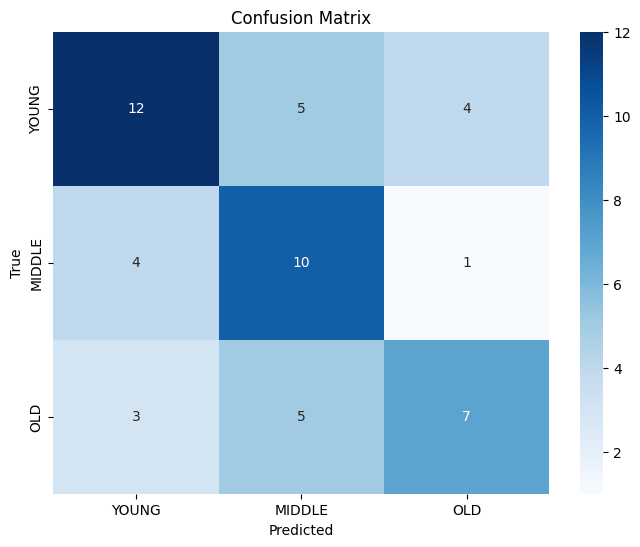

In [20]:
# Ottieni le predizioni e le etichette corrispondenti
predictions = trainer.predict(test_dataset)

# Predizioni
y_pred = predictions.predictions.argmax(axis=1)

# Etichette vere corrispondenti alle predizioni
y_true = predictions.label_ids

# Stampa il report di classificazione
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=["YOUNG", "MIDDLE", "OLD"]))

# Matrice di confusione
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=["YOUNG", "MIDDLE", "OLD"],
            yticklabels=["YOUNG", "MIDDLE", "OLD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


              precision    recall  f1-score   support

       YOUNG       0.73      0.38      0.50        21
      MIDDLE       0.40      0.93      0.56        15
         OLD       0.60      0.20      0.30        15

    accuracy                           0.49        51
   macro avg       0.58      0.50      0.45        51
weighted avg       0.59      0.49      0.46        51



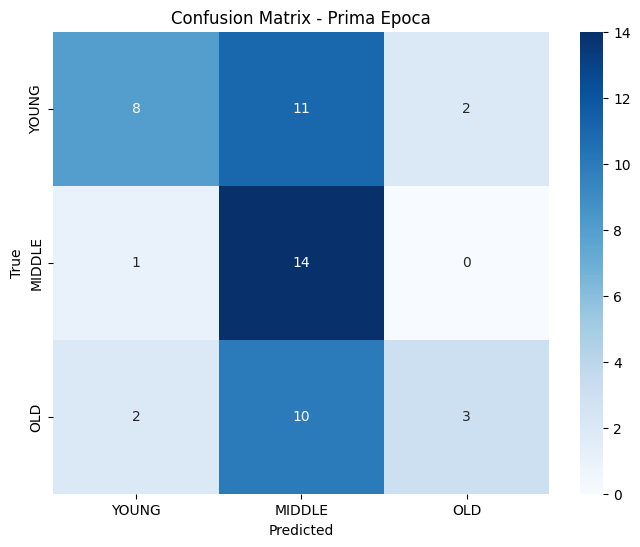

In [23]:
from transformers import AutoModelForImageClassification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Percorso del checkpoint della prima epoca
first_epoch_checkpoint = "./results/checkpoint-12"  # Modifica con il percorso corretto

# Carica il modello dal checkpoint
model = AutoModelForImageClassification.from_pretrained(first_epoch_checkpoint)

# Aggiorna il modello del Trainer con i pesi della prima epoca
trainer.model = model

# Ottieni le predizioni sul dataset di test
predictions = trainer.predict(test_dataset)

# Predizioni e etichette
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

# Calcola e stampa il report di classificazione
print(classification_report(y_true, y_pred, target_names=["YOUNG", "MIDDLE", "OLD"]))

# Matrice di confusione
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=["YOUNG", "MIDDLE", "OLD"],
            yticklabels=["YOUNG", "MIDDLE", "OLD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Prima Epoca")
plt.show()


In [24]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
from PIL import Image
import torch

# Carica il modello con i pesi della prima epoca
first_epoch_checkpoint = "./results/checkpoint-12"  # Modifica con il percorso corretto
model_first_epoch = AutoModelForImageClassification.from_pretrained(first_epoch_checkpoint)

# Carica il modello con i pesi della seconda epoca
second_epoch_checkpoint = "./results/checkpoint-24"  # Modifica con il percorso corretto
model_second_epoch = AutoModelForImageClassification.from_pretrained(second_epoch_checkpoint)

# Carica il processore delle immagini
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Caricamento di un'immagine dal PC
from google.colab import files

print("Carica un'immagine dal tuo PC:")
uploaded = files.upload()  # Permette di caricare un'immagine dal PC
image_path = next(iter(uploaded))  # Ottieni il percorso del file caricato

# Preprocessamento dell'immagine
image = Image.open(image_path).convert("RGB")
inputs = image_processor(images=image, return_tensors="pt")

# Predizioni con il modello della prima epoca
model_first_epoch.eval()
with torch.no_grad():
    outputs_first_epoch = model_first_epoch(**inputs)
    predicted_class_first_epoch = torch.argmax(outputs_first_epoch.logits, dim=1).item()

# Predizioni con il modello della seconda epoca
model_second_epoch.eval()
with torch.no_grad():
    outputs_second_epoch = model_second_epoch(**inputs)
    predicted_class_second_epoch = torch.argmax(outputs_second_epoch.logits, dim=1).item()

# Mappa delle classi
class_labels = ["YOUNG", "MIDDLE", "OLD"]

# Stampa dei risultati
print(f"Predizione con il modello della prima epoca: {class_labels[predicted_class_first_epoch]}")
print(f"Predizione con il modello della seconda epoca: {class_labels[predicted_class_second_epoch]}")



Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Carica un'immagine dal tuo PC:


Saving Fototessera.jpeg to Fototessera.jpeg
Predizione con il modello della prima epoca: YOUNG
Predizione con il modello della seconda epoca: YOUNG


PROVIAMO CON UN NUOVO MODELLO

In [36]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import time
import pandas as pd
from PIL import Image

# **1. Configurazione**
device = torch.device("cpu")  # Usa la CPU
num_classes = 3  # Tre classi: YOUNG, MIDDLE, OLD
batch_size = 32
learning_rate = 1e-4
num_epochs = 2  # Numero massimo di epoche
patience = 2  # Early stopping: ferma l'addestramento dopo 2 epoche senza miglioramenti

# **2. Dataset personalizzato**
class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.label_map[label]
        return image, label

# **3. Preprocessamento**
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Dimensioni richieste da AlexNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# **4. Caricamento dei dataset**
data_dir = "dataset"  # Directory principale
train_dataset = CustomDataset(
    annotations_file=os.path.join(data_dir, "train", "annotations_train.csv"),
    img_dir=os.path.join(data_dir, "train"),
    transform=transform,
)
val_dataset = CustomDataset(
    annotations_file=os.path.join(data_dir, "validation", "annotations_validation.csv"),
    img_dir=os.path.join(data_dir, "validation"),
    transform=transform,
)
test_dataset = CustomDataset(
    annotations_file=os.path.join(data_dir, "test", "annotations_test.csv"),
    img_dir=os.path.join(data_dir, "test"),
    transform=transform,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **5. Carica AlexNet pre-addestrato**
model = models.alexnet(pretrained=True)  # Modello pre-addestrato su ImageNet
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adatta l'output
model = model.to(device)

# **6. Funzione di perdita e ottimizzatore**
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# **7. Early Stopping**
class EarlyStopping:
    def __init__(self, patience=2, verbose=False, path="best_model.pth"):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"✔️ Modello migliorato, salvato in {self.path}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("⚠️ Early stopping attivato")

# **8. Addestramento**
def train_model(model, train_loader, val_loader, num_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoca {epoch+1}/{num_epochs}")

        # Modalità di training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        print(f"Loss di training: {train_loss:.4f}")

        # Modalità di validazione
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Loss di validazione: {val_loss:.4f}")

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping attivato")
            break

    total_time = time.time() - start_time
    print(f"Tempo totale di addestramento: {total_time:.2f} secondi")

    # Carica il miglior modello
    model.load_state_dict(torch.load(early_stopping.path))
    return model

# Addestra il modello
model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, patience=patience)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoca 1/2
Loss di training: 0.7028
Loss di validazione: 0.5536
✔️ Modello migliorato, salvato in best_model.pth
Epoca 2/2
Loss di training: 0.4100
Loss di validazione: 0.4031
✔️ Modello migliorato, salvato in best_model.pth
Tempo totale di addestramento: 1165.16 secondi


<ipython-input-36-953135f8582f>:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


In [37]:
# **9. Valutazione sul test set**
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Stampa il report di classificazione
    print("\nReport di classificazione:")
    print(classification_report(y_true, y_pred, target_names=["YOUNG", "MIDDLE", "OLD"]))

# Valuta il modello
evaluate_model(model, test_loader)


Report di classificazione:
              precision    recall  f1-score   support

       YOUNG       0.75      0.65      0.70        86
      MIDDLE       0.84      0.84      0.84       259
         OLD       0.88      0.92      0.90       259

    accuracy                           0.85       604
   macro avg       0.82      0.80      0.81       604
weighted avg       0.85      0.85      0.85       604



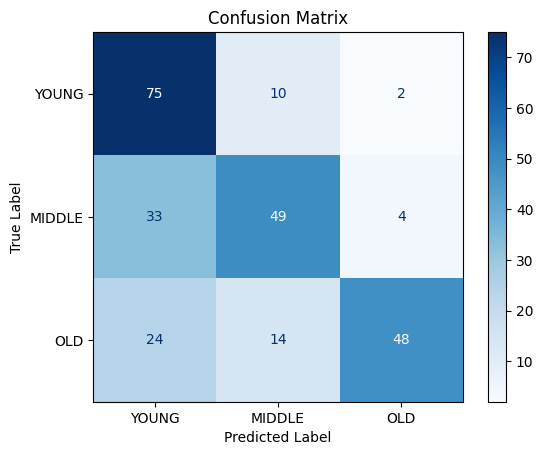

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predizioni e etichette vere (dai risultati del modello)
y_true = []  # Etichette vere
y_pred = []  # Predizioni del modello

# Ottieni predizioni sul test set
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classi del dataset
class_names = ["YOUNG", "MIDDLE", "OLD"]

# Calcola la confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()


In [38]:
import numpy as np

def evaluate_by_class(model, data_loader, criterion, class_names):
    model.eval()
    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))
    class_loss = np.zeros(len(class_names))

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calcolo della loss per ciascuna classe
            for i in range(len(labels)):
                class_loss[labels[i].item()] += loss.item()

            # Predizioni
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                class_total[labels[i].item()] += 1
                if preds[i] == labels[i]:
                    class_correct[labels[i].item()] += 1

    # Calcolo delle metriche
    accuracy_per_class = class_correct / class_total
    average_loss_per_class = class_loss / class_total

    # Stampa delle metriche
    print("\nValutazione per classe:")
    for i, class_name in enumerate(class_names):
        print(f"Classe {class_name}:")
        print(f"  Accuracy: {accuracy_per_class[i] * 100:.2f}%")
        print(f"  Average Loss: {average_loss_per_class[i]:.4f}")

# Classi del dataset
class_names = ["YOUNG", "MIDDLE", "OLD"]

# Valutazione sul validation set
print("\nValidazione:")
evaluate_by_class(model, val_loader, criterion, class_names)

# Valutazione sul test set
print("\nTest:")
evaluate_by_class(model, test_loader, criterion, class_names)



Validazione:

Valutazione per classe:
Classe YOUNG:
  Accuracy: 75.57%
  Average Loss: 0.3991
Classe MIDDLE:
  Accuracy: 82.29%
  Average Loss: 0.3953
Classe OLD:
  Accuracy: 85.71%
  Average Loss: 0.4011

Test:

Valutazione per classe:
Classe YOUNG:
  Accuracy: 65.12%
  Average Loss: 0.3986
Classe MIDDLE:
  Accuracy: 83.78%
  Average Loss: 0.3648
Classe OLD:
  Accuracy: 92.28%
  Average Loss: 0.3691


In [40]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch
from PIL import Image

# Percorso del modello salvato
model_path = "best_model.pth"

# Carica il modello addestrato
model = models.alexnet(pretrained=False)  # Crea un'istanza di AlexNet
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adatta l'output
model.load_state_dict(torch.load(model_path, map_location=device))  # Carica i pesi salvati
model = model.to(device)
model.eval()  # Imposta il modello in modalità valutazione

# Trasformazioni per il preprocessing delle immagini
transform = Compose([
    Resize((224, 224)),  # Dimensioni richieste da AlexNet
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Classi
class_names = ["YOUNG", "MIDDLE", "OLD"]

# Funzione per caricare e predire
def predict_image(image_path):
    # Carica e preprocessa l'immagine
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Aggiunge una dimensione batch

    # Ottieni le predizioni dal modello
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_class = torch.max(outputs, 1)  # Classe con probabilità massima

    # Restituisci la classe predetta
    return class_names[predicted_class.item()]

# Carica un'immagine dal PC
from google.colab import files

uploaded = files.upload()  # Carica l'immagine dal tuo PC
for image_name in uploaded.keys():
    image_path = image_name
    prediction = predict_image(image_path)
    print(f"L'immagine '{image_name}' è stata classificata come: {prediction}")


<ipython-input-40-9a07271a5ed9>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Carica i pesi salvati

Saving fototessera digitale 2.jpg to fototessera digitale 2.jpg
L'immagine 'fototessera digitale 2.jpg' è stata classificata come: OLD
